In [1]:
import matplotlib.pyplot as plt
from IPython.display import Math, display
import numpy as np
import sympy as sp
from scipy import constants as const
from scipy.optimize import minimize_scalar, curve_fit
from scipy import sparse

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si
from twod_trap import DoubleTweezer, TwoSiteLattice
from boson_helpers import *

# Get the Hubbard parameters from the results of a diagonalisation in one function call:

## Show results:

In [16]:
start_line = 63
end_line = 68

n_lines = end_line - start_line + 1
lines = np.arange(start_line,end_line+1,dtype=int)
state_nrs = np.zeros((n_lines,2),dtype=int)
state_nrs[:,1] = 1
degeneracy = np.full(n_lines, True, dtype=bool)

Check at what point the tweezers separate:

line: 63
separation: 1.2750 um


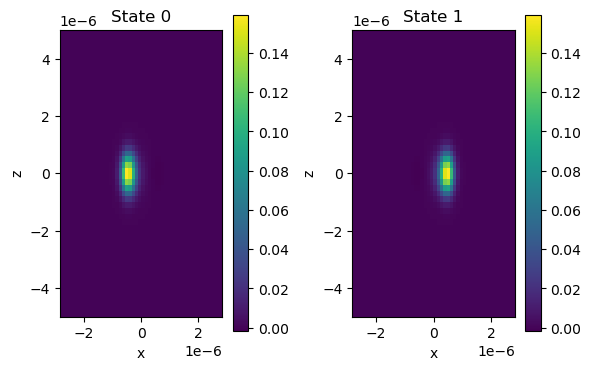

line: 64
separation: 1.3000 um


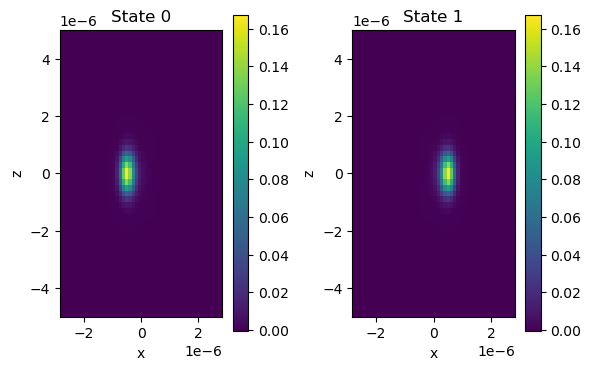

line: 65
separation: 1.3250 um


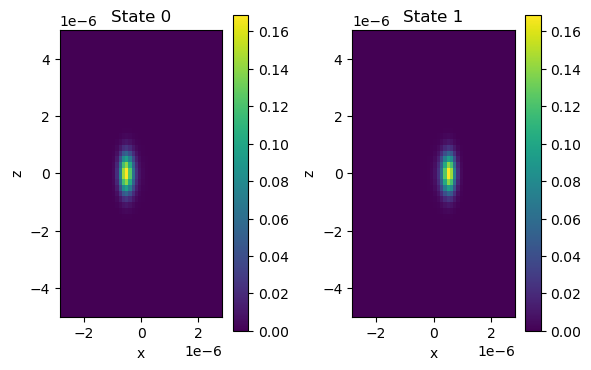

line: 66
separation: 1.3500 um


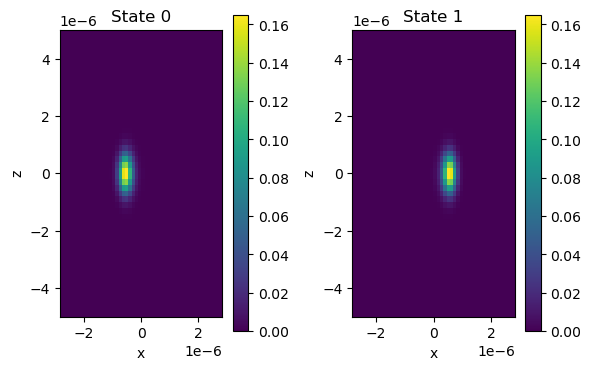

line: 67
separation: 1.3750 um


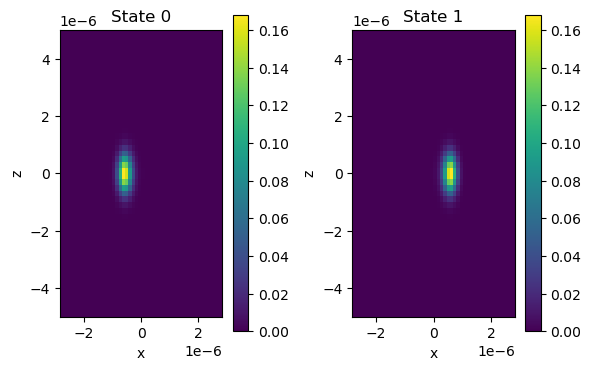

line: 68
separation: 1.4000 um


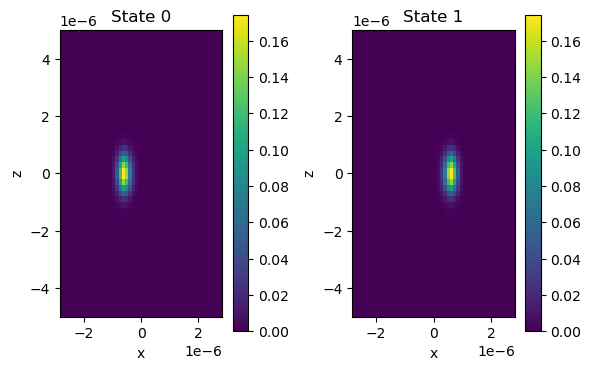

In [17]:
for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]
    
    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    print(f"line: {line}")
    print(f"separation: {trap.subs(trap.distance_tweezers)/si.um:.4f} um")

    #plot wavefunctions
    n_states = 2

    states_plot = [GS_left_1.real, GS_right_1.real]
    #states_plot = [res["states"][state0].real, res["states"][state1].real]
    #states_plot = np.angle(states)
    #states_plot = states.imag
    #states_plot = np.abs(states)**2

    # Create a 1xn_states grid of subplots (1 row, n_states columns)
    fig, axes = plt.subplots(1, n_states, figsize=(6, 4))  # Adjust the size as needed

    # Loop over the state numbers from 0 to n_states-1
    for state_number, ax in zip(range(n_states), axes):
        # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
        im = ax.imshow(states_plot[state_number][:, int(res["size"][1]/2), :].T,
                    extent=[*res["extend"][0], *res["extend"][2]], origin="lower",
                    vmin=np.min(states_plot[state_number]), vmax=np.max(states_plot[state_number]))

        # Set labels for each subplot
        ax.set_xlabel("x")
        ax.set_ylabel("z")
        ax.set_title(f"State {state_number}")
        fig.colorbar(im, ax=ax)  

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

J = [10.76459135  3.9825663   1.41321814  0.48828016  0.16587758  0.05579203] Hz
U_s = [18.16656197 18.94287365 19.55298704 20.05269908 20.47741687 20.84363256] Hz


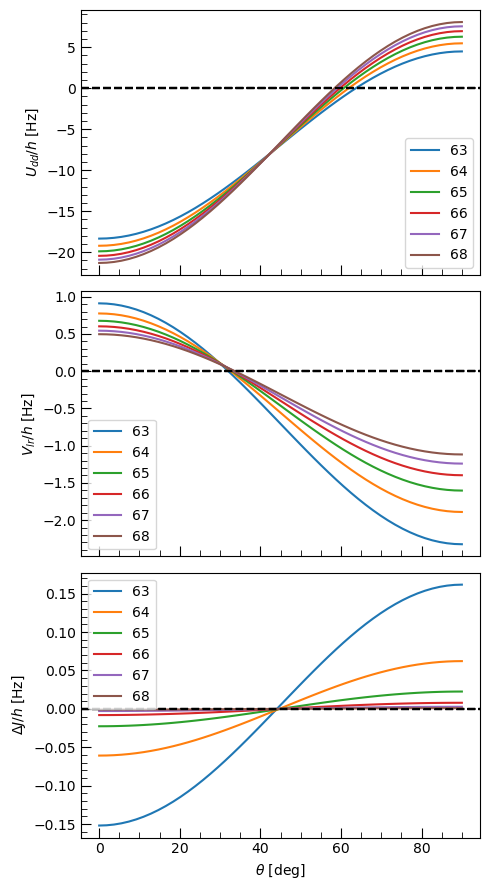

In [18]:
distance = np.zeros_like(lines,dtype=float)
J = np.zeros_like(lines,dtype=float)
#tilt = np.zeros_like(lines,dtype=float)
U_s = np.zeros_like(lines,dtype=float)
U_dds = np.zeros((len(lines),50),dtype=float)
angles = np.zeros((len(lines),50),dtype=float)
V_lrs = np.zeros((len(lines),50),dtype=float)
DeltaJs = np.zeros((len(lines),50),dtype=float)

for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]

    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])

    distance[i] = float(trap.subs(trap.distance_tweezers))
    J[i], U_s[i], U_dds[i], angles[i], V_lrs[i], DeltaJs[i] = analyse_diagonalisation(line,
                                                                state_nr0=state0,
                                                                state_nr1=state1,
                                                                degenerate=degeneracy[i])

    # E_left = (func_ham(GS_left_1.flatten())/GS_left_1.flatten())[0]
    # E_right = (func_ham(GS_right_1.flatten())/GS_right_1.flatten())[0]
    # print(E_left/const.h)
    # print(E_right/const.h)
    # tilt[i] = E_right - E_left

    #omega_left, omega_right = trap.get_both_omega(trap.x)
    #print(f"omega_x = 2pi* {float(trap.subs(omega_left))/2/np.pi:.2f}Hz")
    #omega_left, omega_right = trap.get_both_omega(trap.z)
    #print(f"omega_z = 2pi* {float(trap.subs(omega_left))/2/np.pi:.2f}Hz")

print(f"J = {J/const.h} Hz")
print(f"U_s = {U_s/const.h} Hz")

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(5, 9), sharex=True)

for i, line in enumerate(lines):
    # Plot U_dd
    axes[0].plot(np.rad2deg(angles[i]), U_dds[i]/const.h,label=f"{line}")
    axes[0].axhline(0, color="black", ls="--")
    axes[0].set_ylabel(r"$U_{dd} / h$ [Hz]")
    axes[0].legend()

    # Plot NNI
    axes[1].plot(np.rad2deg(angles[i]), V_lrs[i]/const.h,label=f"{line}")
    axes[1].axhline(0, color="black", ls="--")
    axes[1].set_ylabel(r"$V_{lr} / h$ [Hz]")
    axes[1].legend()

    # Plot DIT
    axes[2].plot(np.rad2deg(angles[i]), DeltaJs[i]/const.h,label=f"{line}")
    axes[2].axhline(0, color="black", ls="--")
    axes[2].set_xlabel(r"$\theta$ [deg]")
    axes[2].set_ylabel(r"$\Delta J / h$ [Hz]")
    axes[2].legend()

    # Customize ticks for all subplots
    for ax in axes:
        ax.tick_params(axis='both', which='both', direction='in', length=5)  # Tick marks inside
        ax.tick_params(axis='both', which='major', length=7)  # Major ticks longer
        ax.tick_params(axis='both', which='minor', length=4)  # Minor ticks shorter
        ax.minorticks_on()  # Enable minor ticks

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

x0 = -24.85 nm


C:\Users\naeve\AppData\Local\Temp\ipykernel_25260\3593060390.py:2: RuntimeWarning: overflow encountered in exp
  return A*np.exp((x-d)/x0)


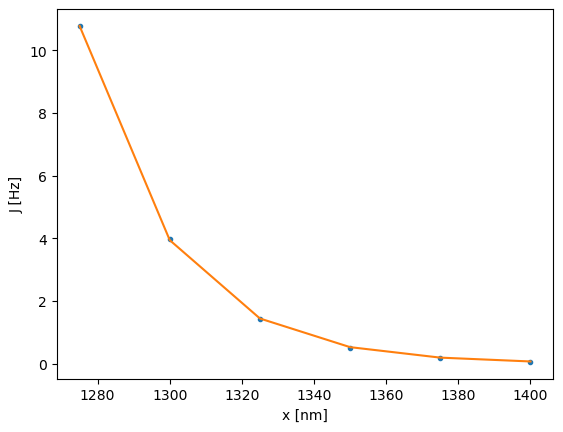

In [20]:
def exponential(x,x0,A,d):
    return A*np.exp((x-d)/x0)

popt, pcov = curve_fit(exponential, distance, J,p0=[-25e-9, 0.1*const.h,1380e-9])

print(f"x0 = {popt[0]/si.nm:.2f} nm")

plt.plot(distance/si.nm, J/const.h,".")
plt.plot(distance/si.nm, exponential(distance,*popt)/const.h)

plt.ylabel("J [Hz]")
plt.xlabel("x [nm]")
plt.show()

# Do the same for larger trapping frequency:

In [46]:
start_line = 74
end_line = 84

n_lines = end_line - start_line + 1
lines = np.arange(start_line,end_line+1,dtype=int)
state_nrs = np.zeros((n_lines,2),dtype=int)
state_nrs[:,1] = 1
degeneracy = np.full(n_lines, True, dtype=bool)

line: 74
separation: 0.7571 um


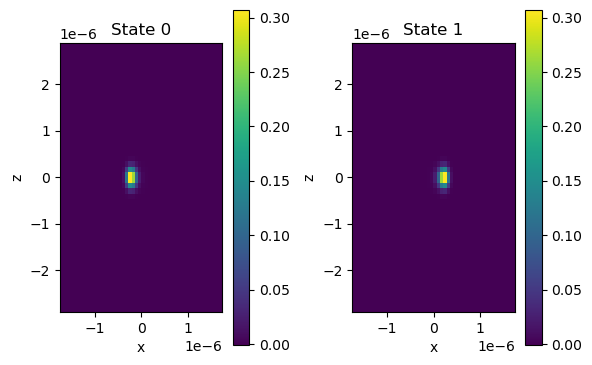

line: 75
separation: 0.7714 um


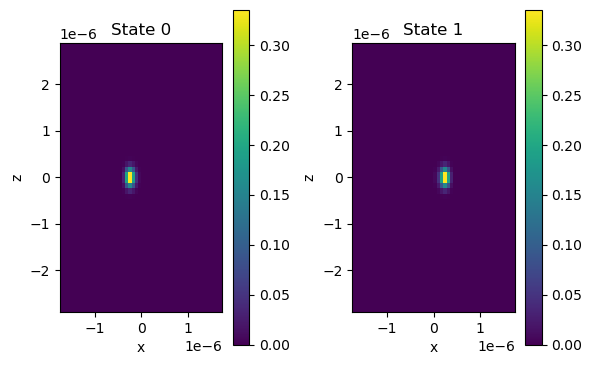

line: 76
separation: 0.7857 um


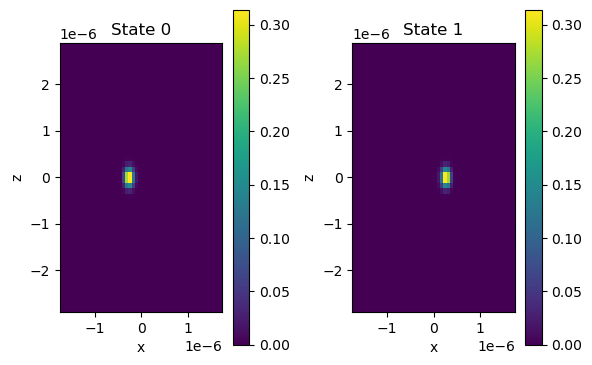

line: 77
separation: 0.8000 um


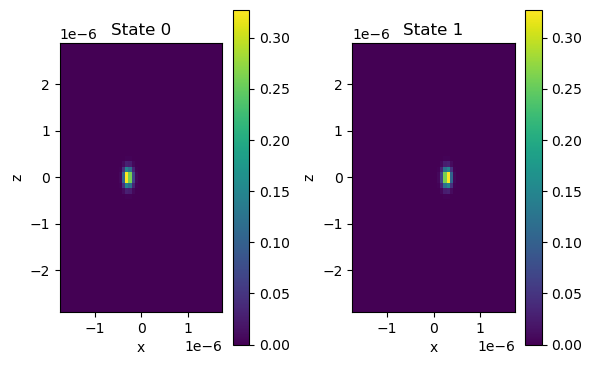

line: 78
separation: 0.8143 um


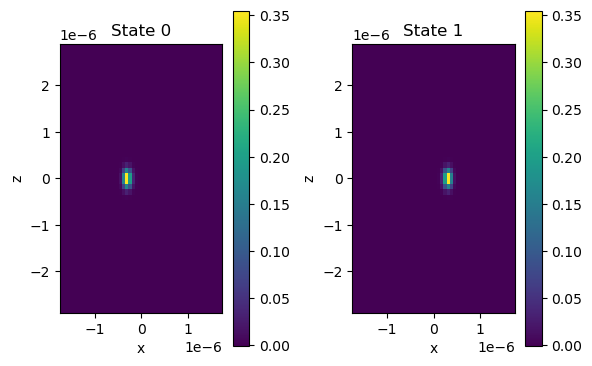

line: 79
separation: 0.8286 um


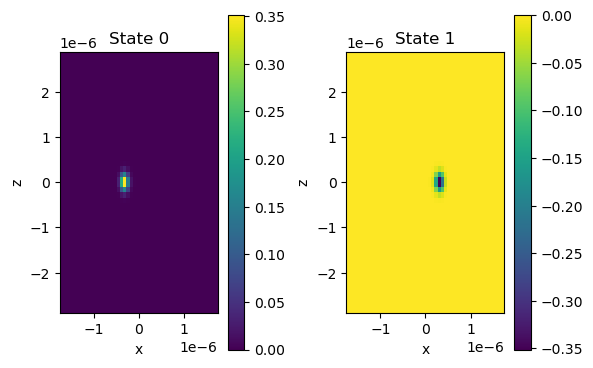

line: 80
separation: 0.8429 um


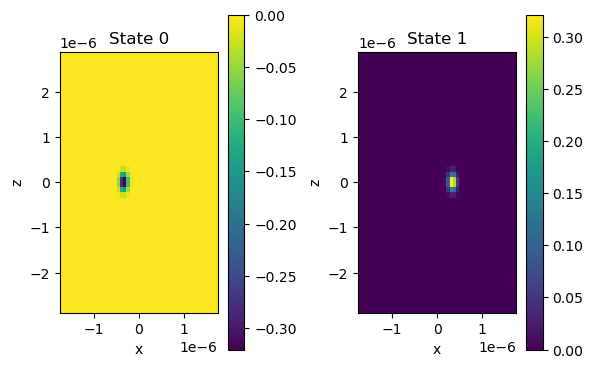

line: 81
separation: 0.8571 um


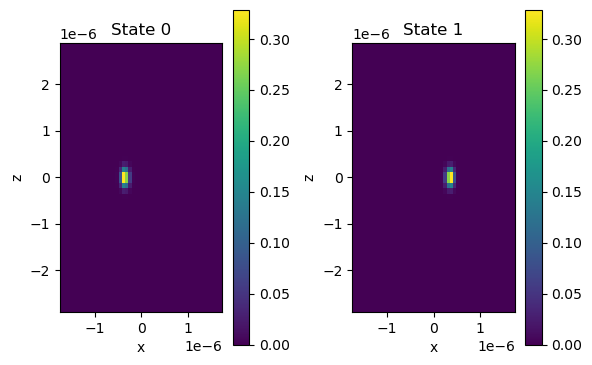

line: 82
separation: 0.8714 um


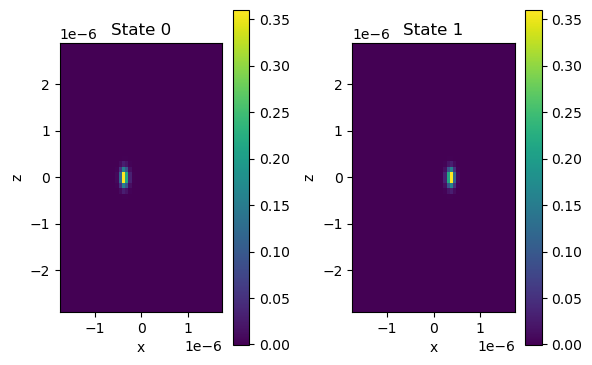

line: 83
separation: 0.8857 um


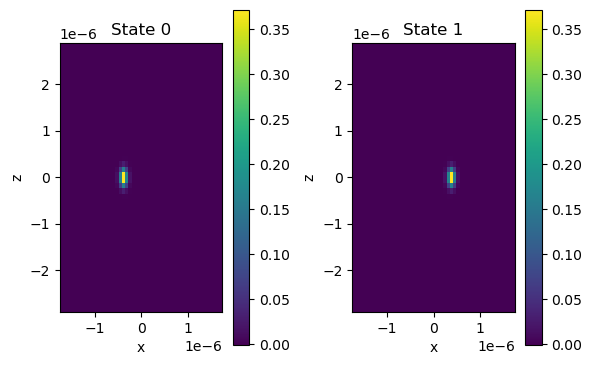

line: 84
separation: 0.9000 um


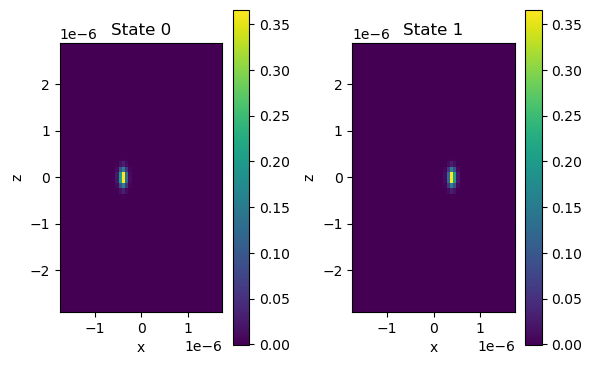

In [47]:
for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]
    
    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    print(f"line: {line}")
    print(f"separation: {trap.subs(trap.distance_tweezers)/si.um:.4f} um")

    #plot wavefunctions
    n_states = 2

    states_plot = [GS_left_1.real, GS_right_1.real]
    #states_plot = [res["states"][state0].real, res["states"][state1].real]
    #states_plot = np.angle(states)
    #states_plot = states.imag
    #states_plot = np.abs(states)**2

    # Create a 1xn_states grid of subplots (1 row, n_states columns)
    fig, axes = plt.subplots(1, n_states, figsize=(6, 4))  # Adjust the size as needed

    # Loop over the state numbers from 0 to n_states-1
    for state_number, ax in zip(range(n_states), axes):
        # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
        im = ax.imshow(states_plot[state_number][:, int(res["size"][1]/2), :].T,
                    extent=[*res["extend"][0], *res["extend"][2]], origin="lower",
                    vmin=np.min(states_plot[state_number]), vmax=np.max(states_plot[state_number]))

        # Set labels for each subplot
        ax.set_xlabel("x")
        ax.set_ylabel("z")
        ax.set_title(f"State {state_number}")
        fig.colorbar(im, ax=ax)  

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

J = [12.28626301  1.50269376  0.28180441  0.39235061  1.52504364 -1.60494868
 -0.47799808  0.29744892  1.7027932   2.98919735  2.78954554] Hz
U_s = [433.34720095 475.59990671 469.97352607 499.39261094 553.13492095
 548.50091279 510.71591276 527.06457265 592.28021292 631.4864043
 611.36628181] Hz


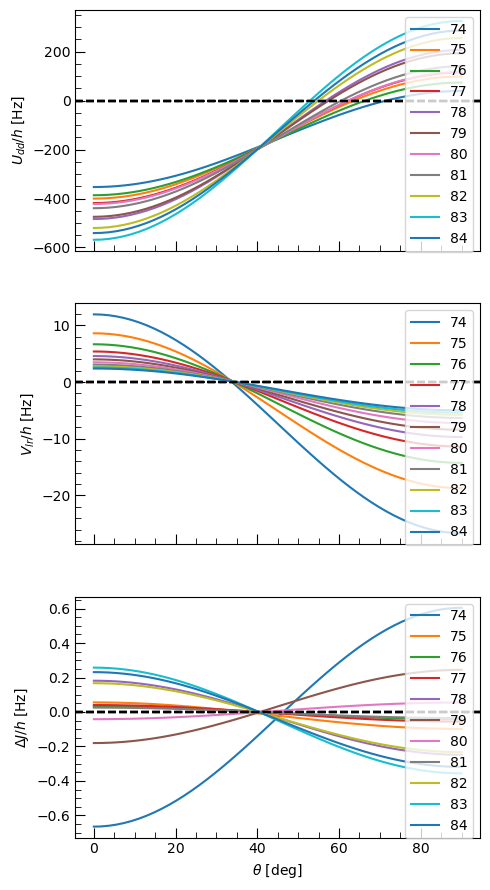

In [48]:
distance = np.zeros_like(lines,dtype=float)
J = np.zeros_like(lines,dtype=float)
#tilt = np.zeros_like(lines,dtype=float)
U_s = np.zeros_like(lines,dtype=float)
U_dds = np.zeros((len(lines),50),dtype=float)
angles = np.zeros((len(lines),50),dtype=float)
V_lrs = np.zeros((len(lines),50),dtype=float)
DeltaJs = np.zeros((len(lines),50),dtype=float)

for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]

    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    distance[i] = float(trap.subs(trap.distance_tweezers))
    J[i], U_s[i], U_dds[i], angles[i], V_lrs[i], DeltaJs[i] = analyse_diagonalisation(line,
                                                                state_nr0=state0,
                                                                state_nr1=state1,
                                                                degenerate=degeneracy[i])

    # E_left = (func_ham(GS_left_1.flatten())/GS_left_1.flatten())[0]
    # E_right = (func_ham(GS_right_1.flatten())/GS_right_1.flatten())[0]
    # print(E_left/const.h)
    # print(E_right/const.h)
    # tilt[i] = E_right - E_left

    #omega_left, omega_right = trap.get_both_omega(trap.x)
    #print(f"omega_x = 2pi* {float(trap.subs(omega_left))/2/np.pi:.2f}Hz")
    #omega_left, omega_right = trap.get_both_omega(trap.z)
    #print(f"omega_z = 2pi* {float(trap.subs(omega_left))/2/np.pi:.2f}Hz")

print(f"J = {J/const.h} Hz")
print(f"U_s = {U_s/const.h} Hz")

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(5, 9), sharex=True)

for i, line in enumerate(lines):
    # Plot U_dd
    axes[0].plot(np.rad2deg(angles[i]), U_dds[i]/const.h,label=f"{line}")
    axes[0].axhline(0, color="black", ls="--")
    axes[0].set_ylabel(r"$U_{dd} / h$ [Hz]")
    axes[0].legend()

    # Plot NNI
    axes[1].plot(np.rad2deg(angles[i]), V_lrs[i]/const.h,label=f"{line}")
    axes[1].axhline(0, color="black", ls="--")
    axes[1].set_ylabel(r"$V_{lr} / h$ [Hz]")
    axes[1].legend()

    # Plot DIT
    axes[2].plot(np.rad2deg(angles[i]), DeltaJs[i]/const.h,label=f"{line}")
    axes[2].axhline(0, color="black", ls="--")
    axes[2].set_xlabel(r"$\theta$ [deg]")
    axes[2].set_ylabel(r"$\Delta J / h$ [Hz]")
    axes[2].legend()

    # Customize ticks for all subplots
    for ax in axes:
        ax.tick_params(axis='both', which='both', direction='in', length=5)  # Tick marks inside
        ax.tick_params(axis='both', which='major', length=7)  # Major ticks longer
        ax.tick_params(axis='both', which='minor', length=4)  # Minor ticks shorter
        ax.minorticks_on()  # Enable minor ticks

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

x0 = -6.91 nm


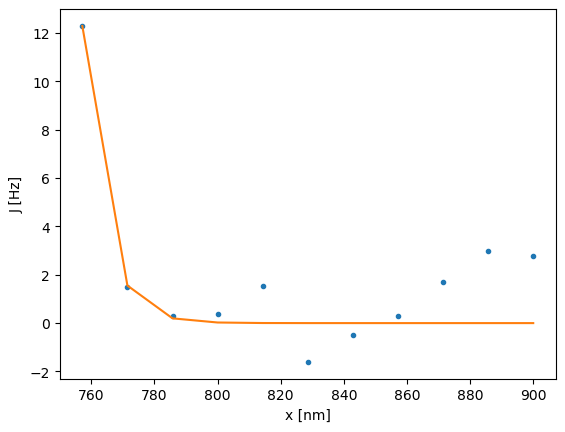

In [49]:
def exponential(x,x0,A,d):
    return A*np.exp((x-d)/x0)

popt, pcov = curve_fit(exponential, distance, J,p0=[-5e-9, 0.1*const.h,770e-9])

print(f"x0 = {popt[0]/si.nm:.2f} nm")

plt.plot(distance/si.nm, J/const.h,".")
plt.plot(distance/si.nm, exponential(distance,*popt)/const.h)

plt.ylabel("J [Hz]")
plt.xlabel("x [nm]")
plt.show()

Seems like we need to control the tweezer distance within about 10nm

In [39]:
start_line = 88
end_line = 94

n_lines = end_line - start_line + 1
lines = np.arange(start_line,end_line+1,dtype=int)
state_nrs = np.zeros((n_lines,2),dtype=int)
state_nrs[:,1] = 1
degeneracy = np.full(n_lines, True, dtype=bool)

line: 88
separation: 0.7319 um


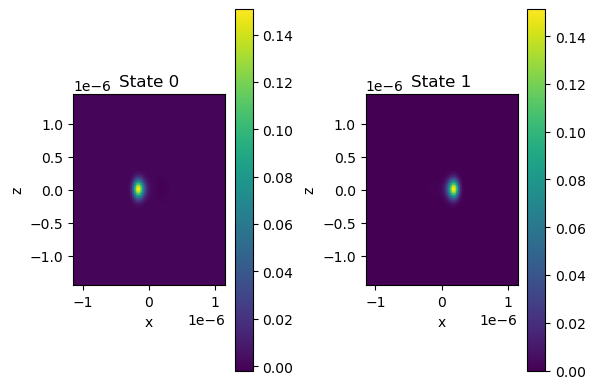

line: 89
separation: 0.7428 um


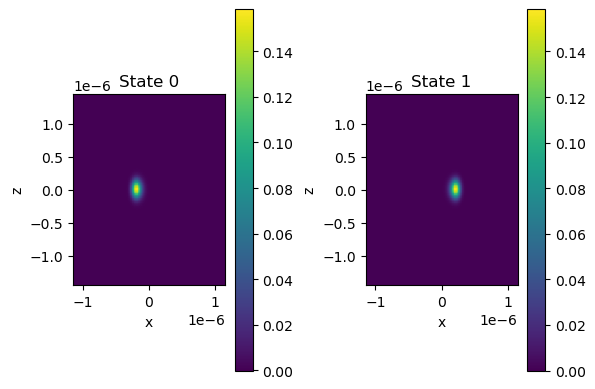

line: 90
separation: 0.7539 um


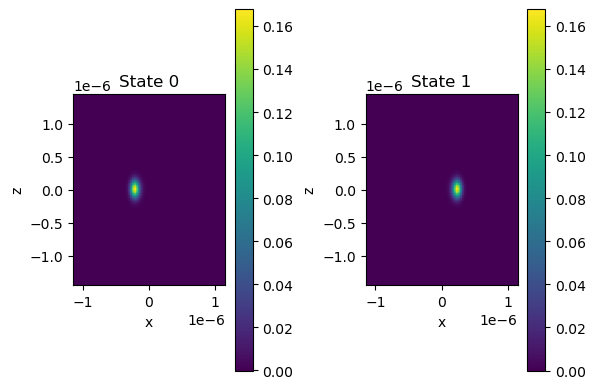

line: 91
separation: 0.7652 um


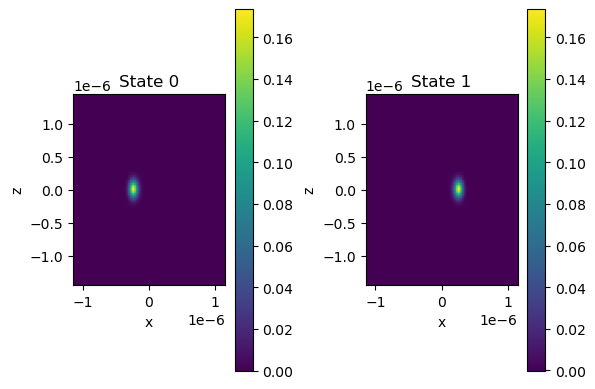

line: 92
separation: 0.7766 um


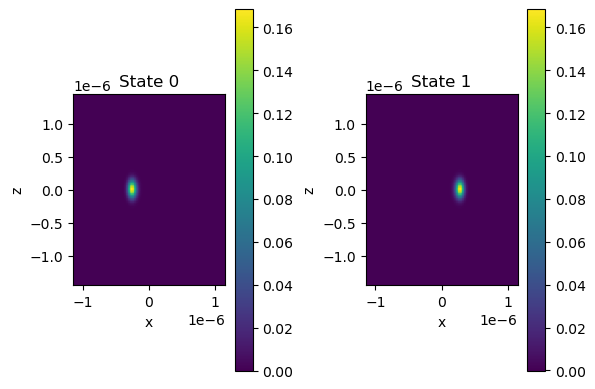

line: 93
separation: 0.7882 um


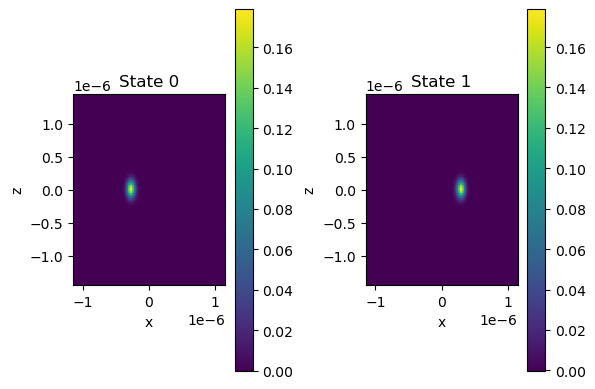

line: 94
separation: 0.8000 um


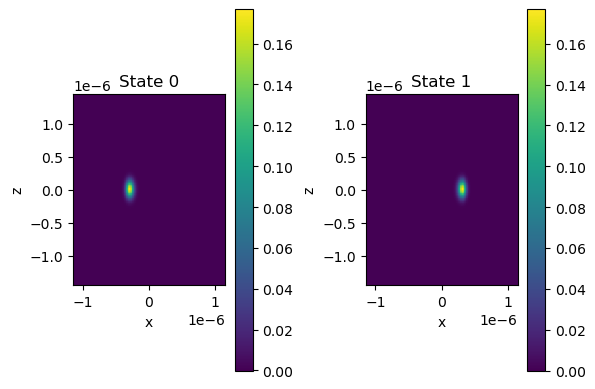

In [40]:
for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]
    
    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    print(f"line: {line}")
    print(f"separation: {trap.subs(trap.distance_tweezers)/si.um:.4f} um")

    #plot wavefunctions
    n_states = 2

    states_plot = [GS_left_1.real, GS_right_1.real]
    #states_plot = [res["states"][state0].real, res["states"][state1].real]
    #states_plot = np.angle(states)
    #states_plot = states.imag
    #states_plot = np.abs(states)**2

    # Create a 1xn_states grid of subplots (1 row, n_states columns)
    fig, axes = plt.subplots(1, n_states, figsize=(6, 4))  # Adjust the size as needed

    # Loop over the state numbers from 0 to n_states-1
    for state_number, ax in zip(range(n_states), axes):
        # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
        im = ax.imshow(states_plot[state_number][:, int(res["size"][1]/2), :].T,
                    extent=[*res["extend"][0], *res["extend"][2]], origin="lower",
                    vmin=np.min(states_plot[state_number]), vmax=np.max(states_plot[state_number]))

        # Set labels for each subplot
        ax.set_xlabel("x")
        ax.set_ylabel("z")
        ax.set_title(f"State {state_number}")
        fig.colorbar(im, ax=ax)  

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

J = [ 2.33669250e+01  5.14466514e-01  6.52124558e-03  4.38240060e-05
 -1.47570996e-05 -2.94650800e-05 -5.31258918e-05] Hz
U_s = [1334.81641772 1472.89943189 1567.97881363 1644.15384339 1707.63613706
 1764.79497325 1808.30193624] Hz


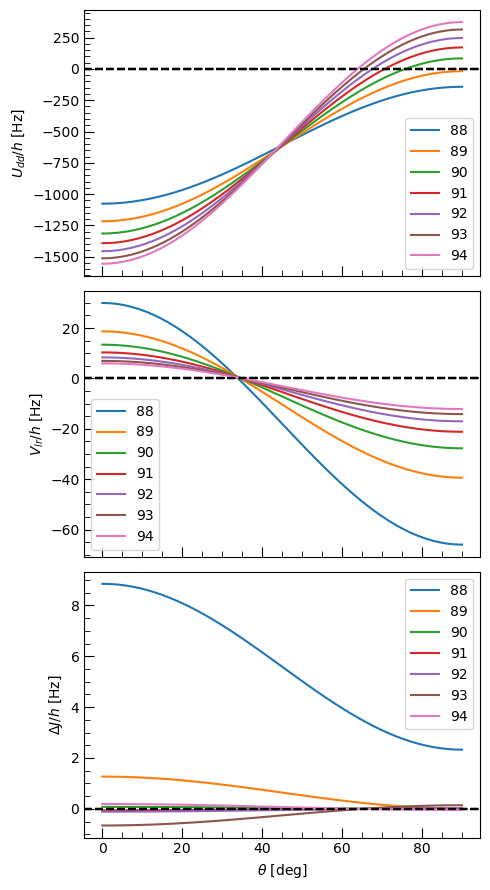

In [41]:
distance = np.zeros_like(lines,dtype=float)
J = np.zeros_like(lines,dtype=float)
#tilt = np.zeros_like(lines,dtype=float)
U_s = np.zeros_like(lines,dtype=float)
U_dds = np.zeros((len(lines),50),dtype=float)
angles = np.zeros((len(lines),50),dtype=float)
V_lrs = np.zeros((len(lines),50),dtype=float)
DeltaJs = np.zeros((len(lines),50),dtype=float)

for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]

    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    distance[i] = float(trap.subs(trap.distance_tweezers))
    J[i], U_s[i], U_dds[i], angles[i], V_lrs[i], DeltaJs[i] = analyse_diagonalisation(line,
                                                                state_nr0=state0,
                                                                state_nr1=state1,
                                                                degenerate=degeneracy[i])

    # E_left = (func_ham(GS_left_1.flatten())/GS_left_1.flatten())[0]
    # E_right = (func_ham(GS_right_1.flatten())/GS_right_1.flatten())[0]
    # print(E_left/const.h)
    # print(E_right/const.h)
    # tilt[i] = E_right - E_left

    #omega_left, omega_right = trap.get_both_omega(trap.x)
    #print(f"omega_x = 2pi* {float(trap.subs(omega_left))/2/np.pi:.2f}Hz")
    #omega_left, omega_right = trap.get_both_omega(trap.z)
    #print(f"omega_z = 2pi* {float(trap.subs(omega_left))/2/np.pi:.2f}Hz")

print(f"J = {J/const.h} Hz")
print(f"U_s = {U_s/const.h} Hz")

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(5, 9), sharex=True)

for i, line in enumerate(lines):
    # Plot U_dd
    axes[0].plot(np.rad2deg(angles[i]), U_dds[i]/const.h,label=f"{line}")
    axes[0].axhline(0, color="black", ls="--")
    axes[0].set_ylabel(r"$U_{dd} / h$ [Hz]")
    axes[0].legend()

    # Plot NNI
    axes[1].plot(np.rad2deg(angles[i]), V_lrs[i]/const.h,label=f"{line}")
    axes[1].axhline(0, color="black", ls="--")
    axes[1].set_ylabel(r"$V_{lr} / h$ [Hz]")
    axes[1].legend()

    # Plot DIT
    axes[2].plot(np.rad2deg(angles[i]), DeltaJs[i]/const.h,label=f"{line}")
    axes[2].axhline(0, color="black", ls="--")
    axes[2].set_xlabel(r"$\theta$ [deg]")
    axes[2].set_ylabel(r"$\Delta J / h$ [Hz]")
    axes[2].legend()

    # Customize ticks for all subplots
    for ax in axes:
        ax.tick_params(axis='both', which='both', direction='in', length=5)  # Tick marks inside
        ax.tick_params(axis='both', which='major', length=7)  # Major ticks longer
        ax.tick_params(axis='both', which='minor', length=4)  # Minor ticks shorter
        ax.minorticks_on()  # Enable minor ticks

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

x0 = -2.87 nm


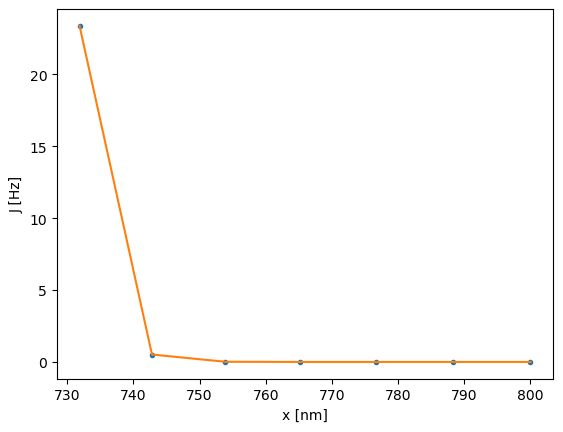

In [45]:
def exponential(x,x0,A,d):
    return A*np.exp((x-d)/x0)

popt, pcov = curve_fit(exponential, distance, J,p0=[-5e-9, 0.1*const.h,750e-9])

print(f"x0 = {popt[0]/si.nm:.2f} nm")

plt.plot(distance/si.nm, J/const.h,".")
plt.plot(distance/si.nm, exponential(distance,*popt)/const.h)

plt.ylabel("J [Hz]")
plt.xlabel("x [nm]")
plt.show()

Seems like the data is not good, since we're only using small grid.

## Try to replicate the Kaufman paper with dysprosium, trap frequency 96kHz/2pi (at separation), 0.71um waist and 808nm separation:

They have J~200Hz, so I would expect roughly 100Hz for Dysprosium

In [54]:
start_line = 96
end_line = 96

n_lines = end_line - start_line + 1
lines = np.arange(start_line,end_line+1,dtype=int)
state_nrs = np.zeros((n_lines,2),dtype=int)
state_nrs[:,1] = 1
degeneracy = np.full(n_lines, True, dtype=bool)

J = [0.63865845] Hz
U_s = [269.17665202] Hz


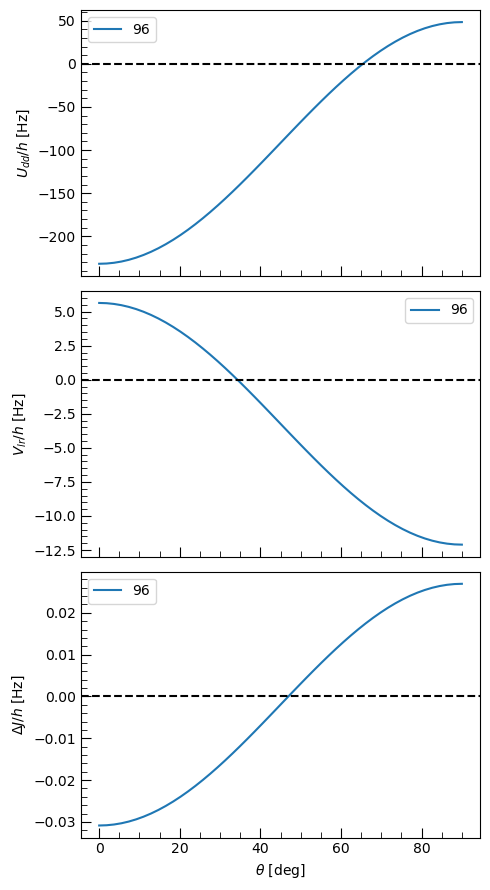

In [55]:
distance = np.zeros_like(lines,dtype=float)
J = np.zeros_like(lines,dtype=float)
#tilt = np.zeros_like(lines,dtype=float)
U_s = np.zeros_like(lines,dtype=float)
U_dds = np.zeros((len(lines),50),dtype=float)
angles = np.zeros((len(lines),50),dtype=float)
V_lrs = np.zeros((len(lines),50),dtype=float)
DeltaJs = np.zeros((len(lines),50),dtype=float)

for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]

    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    distance[i] = float(trap.subs(trap.distance_tweezers))
    J[i], U_s[i], U_dds[i], angles[i], V_lrs[i], DeltaJs[i] = analyse_diagonalisation(line,
                                                                state_nr0=state0,
                                                                state_nr1=state1,
                                                                degenerate=degeneracy[i])

    # E_left = (func_ham(GS_left_1.flatten())/GS_left_1.flatten())[0]
    # E_right = (func_ham(GS_right_1.flatten())/GS_right_1.flatten())[0]
    # print(E_left/const.h)
    # print(E_right/const.h)
    # tilt[i] = E_right - E_left

    #omega_left, omega_right = trap.get_both_omega(trap.x)
    #print(f"omega_x = 2pi* {float(trap.subs(omega_left))/2/np.pi:.2f}Hz")
    #omega_left, omega_right = trap.get_both_omega(trap.z)
    #print(f"omega_z = 2pi* {float(trap.subs(omega_left))/2/np.pi:.2f}Hz")

print(f"J = {J/const.h} Hz")
print(f"U_s = {U_s/const.h} Hz")

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(5, 9), sharex=True)

for i, line in enumerate(lines):
    # Plot U_dd
    axes[0].plot(np.rad2deg(angles[i]), U_dds[i]/const.h,label=f"{line}")
    axes[0].axhline(0, color="black", ls="--")
    axes[0].set_ylabel(r"$U_{dd} / h$ [Hz]")
    axes[0].legend()

    # Plot NNI
    axes[1].plot(np.rad2deg(angles[i]), V_lrs[i]/const.h,label=f"{line}")
    axes[1].axhline(0, color="black", ls="--")
    axes[1].set_ylabel(r"$V_{lr} / h$ [Hz]")
    axes[1].legend()

    # Plot DIT
    axes[2].plot(np.rad2deg(angles[i]), DeltaJs[i]/const.h,label=f"{line}")
    axes[2].axhline(0, color="black", ls="--")
    axes[2].set_xlabel(r"$\theta$ [deg]")
    axes[2].set_ylabel(r"$\Delta J / h$ [Hz]")
    axes[2].legend()

    # Customize ticks for all subplots
    for ax in axes:
        ax.tick_params(axis='both', which='both', direction='in', length=5)  # Tick marks inside
        ax.tick_params(axis='both', which='major', length=7)  # Major ticks longer
        ax.tick_params(axis='both', which='minor', length=4)  # Minor ticks shorter
        ax.minorticks_on()  # Enable minor ticks

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

See how sensitive this result is in terms of tweezer spacing:

In [71]:
start_line = 98
end_line = 106

n_lines = end_line - start_line + 1
lines = np.arange(start_line,end_line+1,dtype=int)
state_nrs = np.zeros((n_lines,2),dtype=int)
state_nrs[:,1] = 1
degeneracy = np.full(n_lines, True, dtype=bool)

line: 98
separation: 0.7433 um


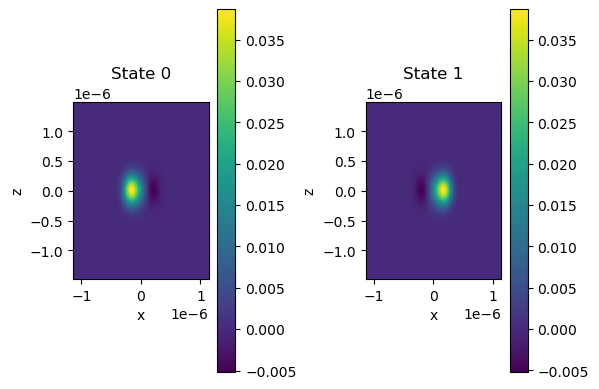

line: 99
separation: 0.7567 um


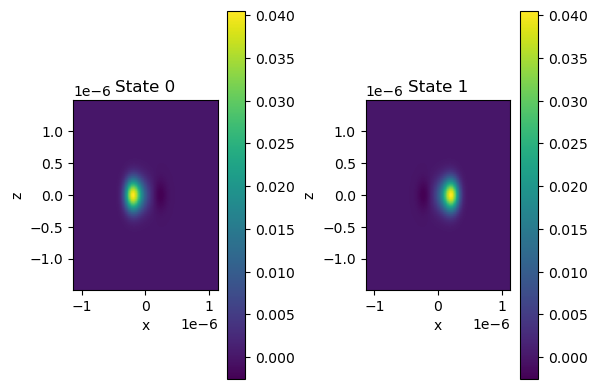

line: 100
separation: 0.7700 um


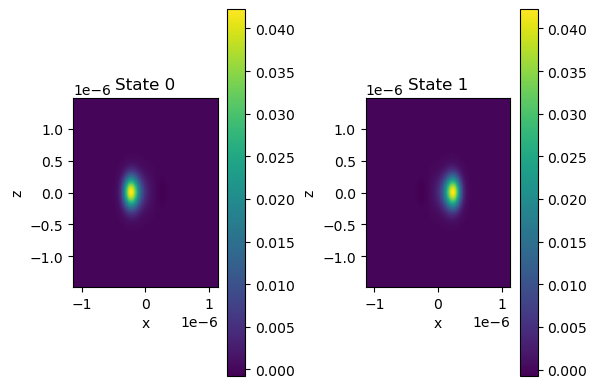

line: 101
separation: 0.7833 um


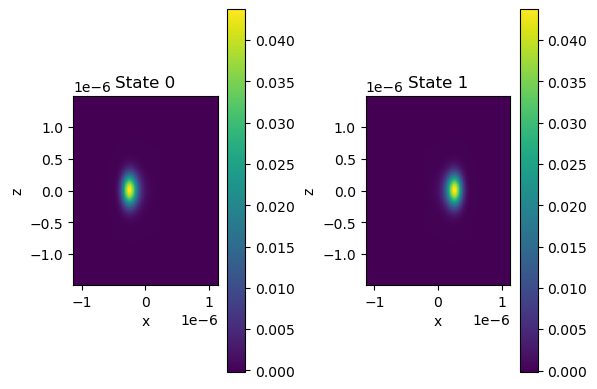

line: 102
separation: 0.7967 um


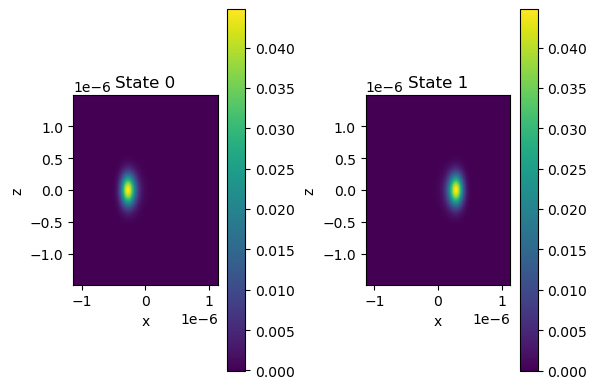

line: 103
separation: 0.8100 um


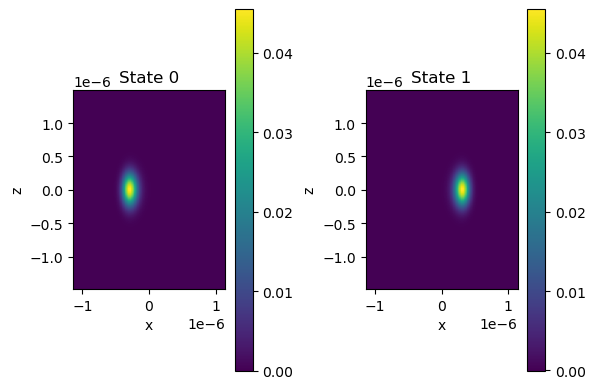

line: 104
separation: 0.8233 um


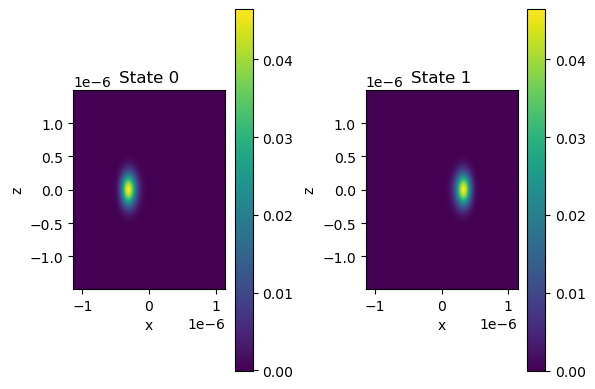

line: 105
separation: 0.8367 um


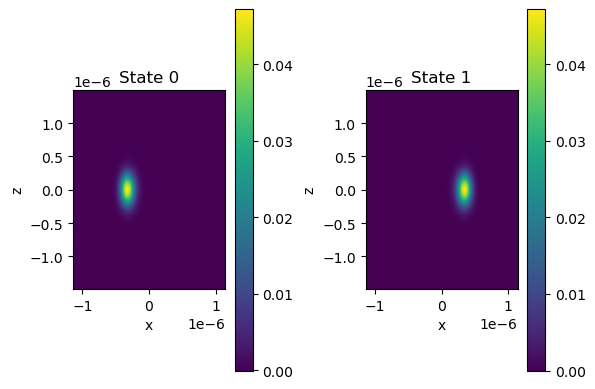

line: 106
separation: 0.8500 um


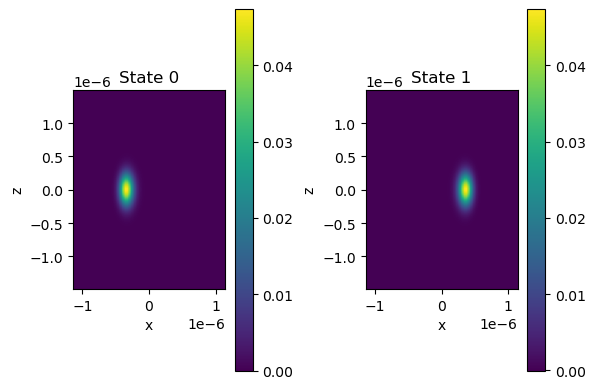

In [72]:
for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]
    
    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    print(f"line: {line}")
    print(f"separation: {trap.subs(trap.distance_tweezers)/si.um:.4f} um")

    #plot wavefunctions
    n_states = 2

    states_plot = [GS_left_1.real, GS_right_1.real]
    #states_plot = [res["states"][state0].real, res["states"][state1].real]
    #states_plot = np.angle(states)
    #states_plot = states.imag
    #states_plot = np.abs(states)**2

    # Create a 1xn_states grid of subplots (1 row, n_states columns)
    fig, axes = plt.subplots(1, n_states, figsize=(6, 4))  # Adjust the size as needed

    # Loop over the state numbers from 0 to n_states-1
    for state_number, ax in zip(range(n_states), axes):
        # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
        im = ax.imshow(states_plot[state_number][:, int(res["size"][1]/2), :].T,
                    extent=[*res["extend"][0], *res["extend"][2]], origin="lower",
                    vmin=np.min(states_plot[state_number]), vmax=np.max(states_plot[state_number]))

        # Set labels for each subplot
        ax.set_xlabel("x")
        ax.set_ylabel("z")
        ax.set_title(f"State {state_number}")
        fig.colorbar(im, ax=ax)  

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

J = [6.47297376e+02 2.57563001e+02 7.12839954e+01 1.54300059e+01
 2.87856788e+00 4.86787632e-01 7.68575361e-02 1.15562296e-02
 1.67843709e-03] Hz
U_s = [192.250924   207.15110813 230.08270887 247.62052937 260.45180538
 270.5648513  278.91147625 285.9887713  292.09844135] Hz


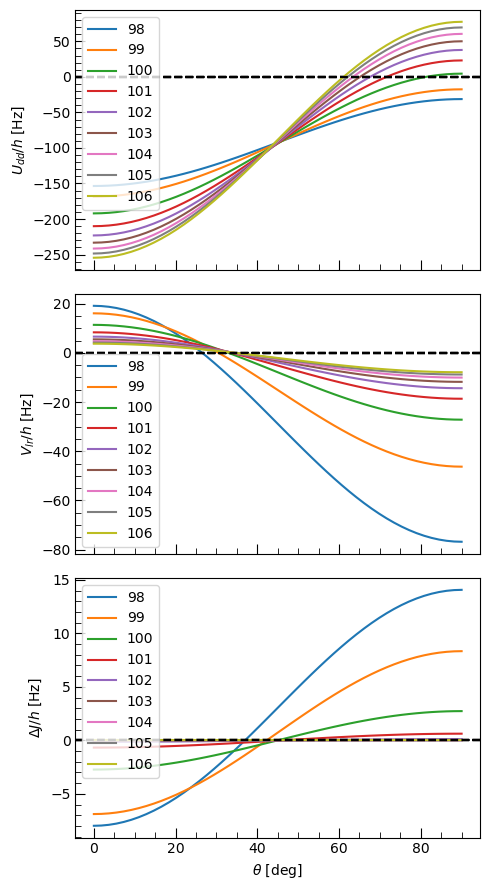

In [73]:
distance = np.zeros_like(lines,dtype=float)
J = np.zeros_like(lines,dtype=float)
#tilt = np.zeros_like(lines,dtype=float)
U_s = np.zeros_like(lines,dtype=float)
U_dds = np.zeros((len(lines),50),dtype=float)
angles = np.zeros((len(lines),50),dtype=float)
V_lrs = np.zeros((len(lines),50),dtype=float)
DeltaJs = np.zeros((len(lines),50),dtype=float)

for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]

    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    distance[i] = float(trap.subs(trap.distance_tweezers))
    J[i], U_s[i], U_dds[i], angles[i], V_lrs[i], DeltaJs[i] = analyse_diagonalisation(line,
                                                                state_nr0=state0,
                                                                state_nr1=state1,
                                                                degenerate=degeneracy[i],
                                                                n_angles=20)

    # E_left = (func_ham(GS_left_1.flatten())/GS_left_1.flatten())[0]
    # E_right = (func_ham(GS_right_1.flatten())/GS_right_1.flatten())[0]
    # print(E_left/const.h)
    # print(E_right/const.h)
    # tilt[i] = E_right - E_left

    #omega_left, omega_right = trap.get_both_omega(trap.x)
    #print(f"omega_x = 2pi* {float(trap.subs(omega_left))/2/np.pi:.2f}Hz")
    #omega_left, omega_right = trap.get_both_omega(trap.z)
    #print(f"omega_z = 2pi* {float(trap.subs(omega_left))/2/np.pi:.2f}Hz")

print(f"J = {J/const.h} Hz")
print(f"U_s = {U_s/const.h} Hz")

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(5, 9), sharex=True)

for i, line in enumerate(lines):
    # Plot U_dd
    axes[0].plot(np.rad2deg(angles[i]), U_dds[i]/const.h,label=f"{line}")
    axes[0].axhline(0, color="black", ls="--")
    axes[0].set_ylabel(r"$U_{dd} / h$ [Hz]")
    axes[0].legend()

    # Plot NNI
    axes[1].plot(np.rad2deg(angles[i]), V_lrs[i]/const.h,label=f"{line}")
    axes[1].axhline(0, color="black", ls="--")
    axes[1].set_ylabel(r"$V_{lr} / h$ [Hz]")
    axes[1].legend()

    # Plot DIT
    axes[2].plot(np.rad2deg(angles[i]), DeltaJs[i]/const.h,label=f"{line}")
    axes[2].axhline(0, color="black", ls="--")
    axes[2].set_xlabel(r"$\theta$ [deg]")
    axes[2].set_ylabel(r"$\Delta J / h$ [Hz]")
    axes[2].legend()

    # Customize ticks for all subplots
    for ax in axes:
        ax.tick_params(axis='both', which='both', direction='in', length=5)  # Tick marks inside
        ax.tick_params(axis='both', which='major', length=7)  # Major ticks longer
        ax.tick_params(axis='both', which='minor', length=4)  # Minor ticks shorter
        ax.minorticks_on()  # Enable minor ticks

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

x0 = -13.23 nm


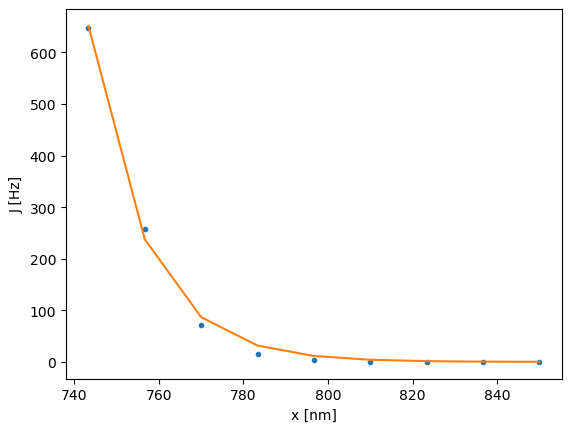

In [74]:
def exponential(x,x0,A,d):
    return A*np.exp((x-d)/x0)

popt, pcov = curve_fit(exponential, distance, J,p0=[-5e-9, 0.1*const.h,750e-9])

print(f"x0 = {popt[0]/si.nm:.2f} nm")

plt.plot(distance/si.nm, J/const.h,".")
plt.plot(distance/si.nm, exponential(distance,*popt)/const.h)

plt.ylabel("J [Hz]")
plt.xlabel("x [nm]")
plt.show()

## Now with trap frequency at separation of 60kHz

In [139]:
start_line = 108
end_line = 117

n_lines = end_line - start_line + 1
lines = np.arange(start_line,end_line+1,dtype=int)
state_nrs = np.zeros((n_lines,2),dtype=int)
state_nrs[:,1] = 1
degeneracy = np.full(n_lines, True, dtype=bool)

line: 108
separation: 0.7300 um


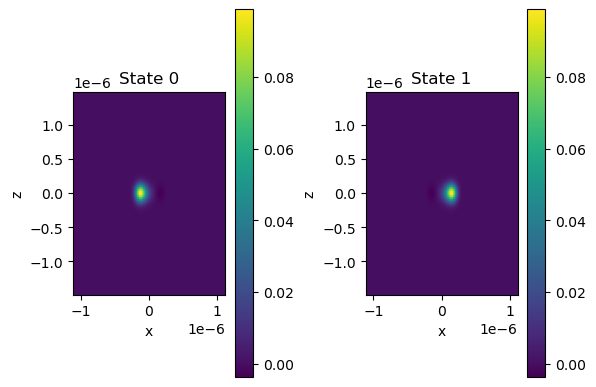

line: 109
separation: 0.7433 um


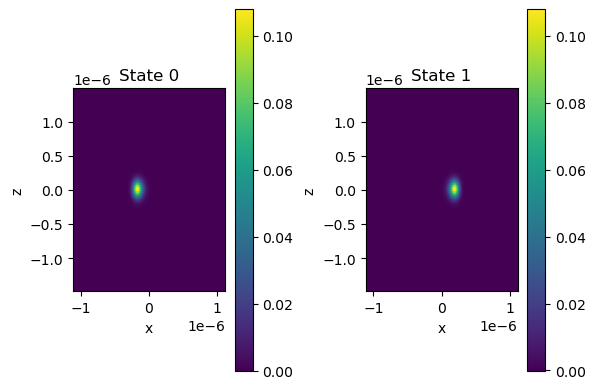

line: 110
separation: 0.7567 um


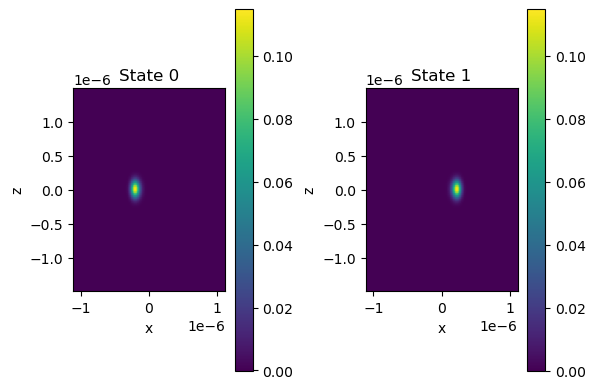

line: 111
separation: 0.7700 um


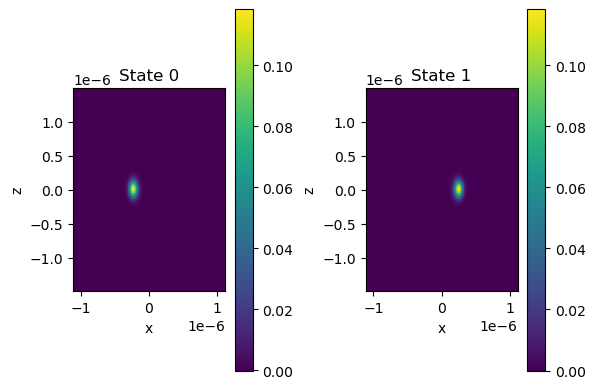

line: 112
separation: 0.7833 um


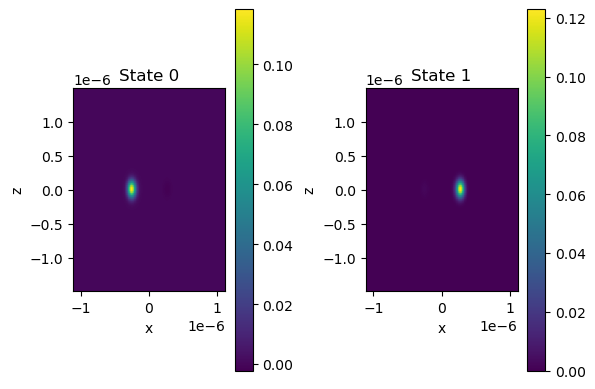

line: 113
separation: 0.7967 um


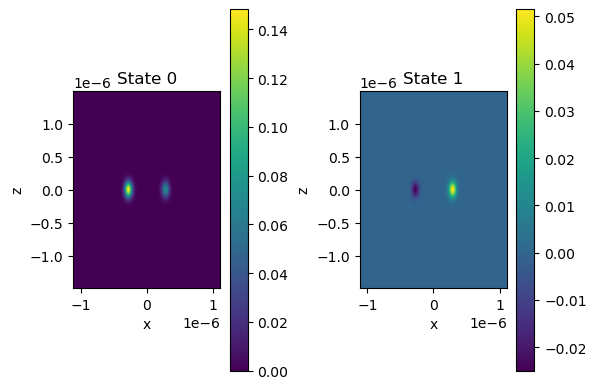

line: 114
separation: 0.8100 um


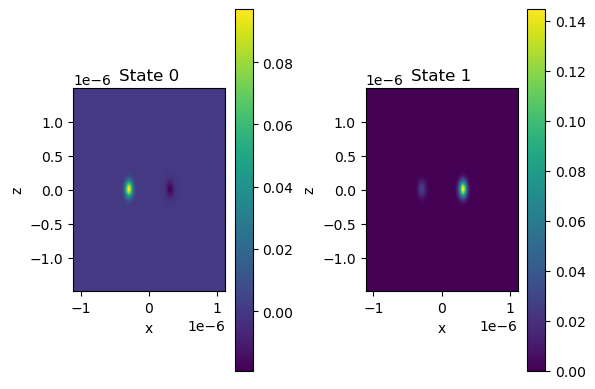

line: 115
separation: 0.8233 um


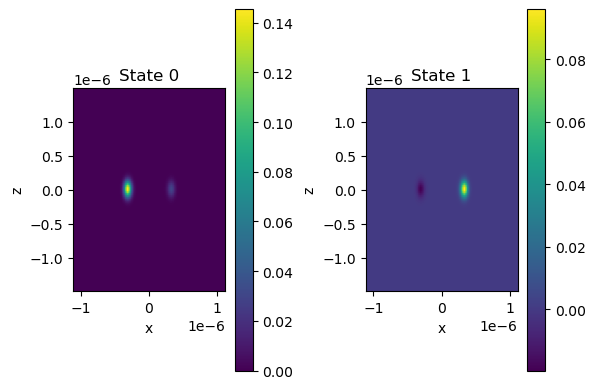

line: 116
separation: 0.8367 um


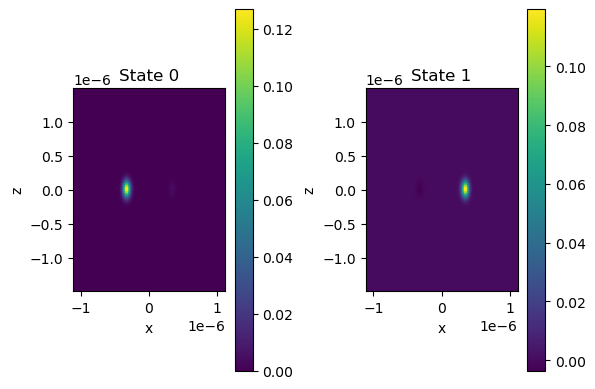

line: 117
separation: 0.8500 um


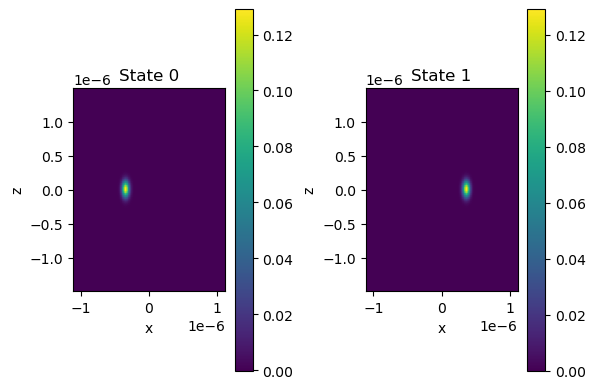

In [140]:
for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]
    
    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    print(f"line: {line}")
    print(f"separation: {trap.subs(trap.distance_tweezers)/si.um:.4f} um")

    #plot wavefunctions
    n_states = 2

    states_plot = [GS_left_1.real, GS_right_1.real]
    #states_plot = [res["states"][state0].real, res["states"][state1].real]
    #states_plot = np.angle(states)
    #states_plot = states.imag
    #states_plot = np.abs(states)**2

    # Create a 1xn_states grid of subplots (1 row, n_states columns)
    fig, axes = plt.subplots(1, n_states, figsize=(6, 4))  # Adjust the size as needed

    # Loop over the state numbers from 0 to n_states-1
    for state_number, ax in zip(range(n_states), axes):
        # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
        im = ax.imshow(states_plot[state_number][:, int(res["size"][1]/2), :].T,
                    extent=[*res["extend"][0], *res["extend"][2]], origin="lower",
                    vmin=np.min(states_plot[state_number]), vmax=np.max(states_plot[state_number]))

        # Set labels for each subplot
        ax.set_xlabel("x")
        ax.set_ylabel("z")
        ax.set_title(f"State {state_number}")
        fig.colorbar(im, ax=ax)  

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

J = [3.95109882e+02 4.55461744e+00 1.58088853e-02 2.68149098e-05
 2.84425642e-08 1.25134430e-09 3.05398467e-09 9.37039197e-09
 8.81733011e-09 1.12933186e-08] Hz
U_s = [1381.51049509 1682.55719597 1852.27750338 1973.65834756 1919.33117469
 4737.22817343  792.13836296 4064.4449819  2600.64434161 2359.95270782] Hz


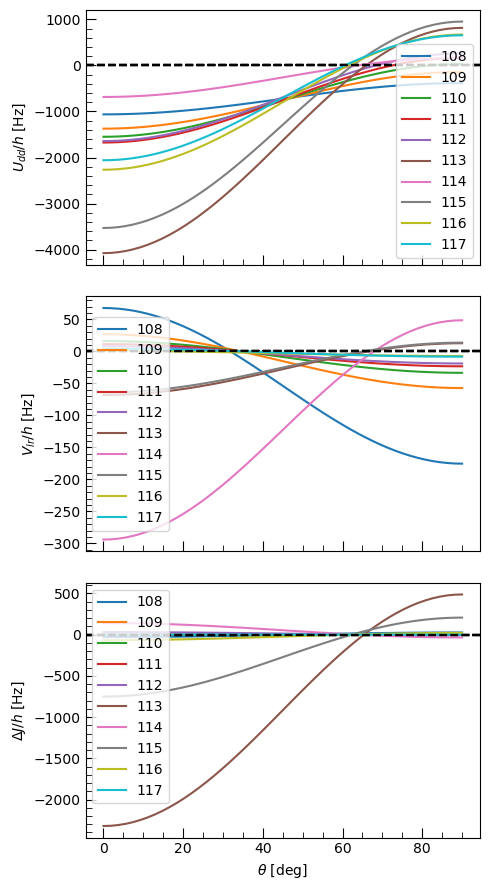

In [141]:
distance = np.zeros_like(lines,dtype=float)
J = np.zeros_like(lines,dtype=float)
#tilt = np.zeros_like(lines,dtype=float)
U_s = np.zeros_like(lines,dtype=float)
U_dds = np.zeros((len(lines),50),dtype=float)
angles = np.zeros((len(lines),50),dtype=float)
V_lrs = np.zeros((len(lines),50),dtype=float)
DeltaJs = np.zeros((len(lines),50),dtype=float)

for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]

    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    distance[i] = float(trap.subs(trap.distance_tweezers))
    J[i], U_s[i], U_dds[i], angles[i], V_lrs[i], DeltaJs[i] = analyse_diagonalisation(line,
                                                                state_nr0=state0,
                                                                state_nr1=state1,
                                                                degenerate=degeneracy[i],
                                                                n_angles=20)

    # E_left = (func_ham(GS_left_1.flatten())/GS_left_1.flatten())[0]
    # E_right = (func_ham(GS_right_1.flatten())/GS_right_1.flatten())[0]
    # print(E_left/const.h)
    # print(E_right/const.h)
    # tilt[i] = E_right - E_left

    #omega_left, omega_right = trap.get_both_omega(trap.x)
    #print(f"omega_x = 2pi* {float(trap.subs(omega_left))/2/np.pi:.2f}Hz")
    #omega_left, omega_right = trap.get_both_omega(trap.z)
    #print(f"omega_z = 2pi* {float(trap.subs(omega_left))/2/np.pi:.2f}Hz")

print(f"J = {J/const.h} Hz")
print(f"U_s = {U_s/const.h} Hz")

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(5, 9), sharex=True)

for i, line in enumerate(lines):
    # Plot U_dd
    axes[0].plot(np.rad2deg(angles[i]), U_dds[i]/const.h,label=f"{line}")
    axes[0].axhline(0, color="black", ls="--")
    axes[0].set_ylabel(r"$U_{dd} / h$ [Hz]")
    axes[0].legend()

    # Plot NNI
    axes[1].plot(np.rad2deg(angles[i]), V_lrs[i]/const.h,label=f"{line}")
    axes[1].axhline(0, color="black", ls="--")
    axes[1].set_ylabel(r"$V_{lr} / h$ [Hz]")
    axes[1].legend()

    # Plot DIT
    axes[2].plot(np.rad2deg(angles[i]), DeltaJs[i]/const.h,label=f"{line}")
    axes[2].axhline(0, color="black", ls="--")
    axes[2].set_xlabel(r"$\theta$ [deg]")
    axes[2].set_ylabel(r"$\Delta J / h$ [Hz]")
    axes[2].legend()

    # Customize ticks for all subplots
    for ax in axes:
        ax.tick_params(axis='both', which='both', direction='in', length=5)  # Tick marks inside
        ax.tick_params(axis='both', which='major', length=7)  # Major ticks longer
        ax.tick_params(axis='both', which='minor', length=4)  # Minor ticks shorter
        ax.minorticks_on()  # Enable minor ticks

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

x0 = -2.99 nm


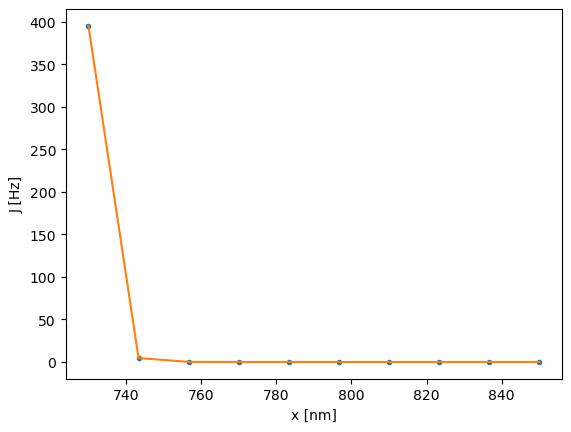

In [142]:
def exponential(x,x0,A,d):
    return A*np.exp((x-d)/x0)

popt, pcov = curve_fit(exponential, distance, J,p0=[-5e-9, 0.1*const.h,750e-9])

print(f"x0 = {popt[0]/si.nm:.2f} nm")

plt.plot(distance/si.nm, J/const.h,".")
plt.plot(distance/si.nm, exponential(distance,*popt)/const.h)

plt.ylabel("J [Hz]")
plt.xlabel("x [nm]")
plt.show()